📓 CELL 1 — Imports & Setup

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.svm import LinearSVC

import joblib


 Load Dataset (IMDb)

In [8]:
df = pd.read_csv(r"C:/Users/Hp/Downloads\IMDB Dataset.csv\IMDB Dataset.csv")  # change path if needed

df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [25]:
print(df.columns)


Index(['review', 'label'], dtype='object')


Label Encoding

In [26]:
# If labels are -1 and 1, convert to 0 and 1
df["label"] = df["label"].replace(-1, 0)

# Keep only the needed columns
df = df[["review", "label"]]
df.head()


,review,label
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


Train/Test Split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    df["review"],
    df["label"],
    test_size=0.2,
    random_state=42
)


 TF-IDF Vectorization (Allowed)

In [28]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words="english"
)

X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

joblib.dump(vectorizer, "vectorizer.pkl")

X_train_vec.shape


(40000, 5000)

Manual SVM Class (FROM SCRATCH)

In [29]:
class ManualSVM:
    def __init__(self, loss="hinge", lr=0.01, epochs=15):
        self.loss = loss
        self.lr = lr
        self.epochs = epochs

    def fit(self, X, y):
        n, d = X.shape
        self.w = np.zeros(d)
        self.b = 0
        self.losses = []

        for epoch in range(self.epochs):
            total_loss = 0

            for i in range(n):
                score = np.dot(self.w, X[i]) + self.b

                if self.loss == "hinge":
                    if y[i] * score < 1:
                        self.w += self.lr * y[i] * X[i]
                        self.b += self.lr * y[i]
                        total_loss += 1 - y[i] * score

                elif self.loss == "squared_hinge":
                    if y[i] * score < 1:
                        diff = 1 - y[i] * score
                        self.w += self.lr * 2 * diff * y[i] * X[i]
                        self.b += self.lr * 2 * diff * y[i]
                        total_loss += diff ** 2

                elif self.loss == "logistic":
                    z = y[i] * score
                    grad = y[i] / (1 + np.exp(z))
                    self.w += self.lr * grad * X[i]
                    self.b += self.lr * grad
                    total_loss += np.log(1 + np.exp(-z))

            self.losses.append(total_loss / n)

    def predict(self, X):
        return np.sign(X @ self.w + self.b)


📓 CELL 7 — Train All Three Manual Models

In [30]:
import pandas as pd

# Convert to pandas temporarily
X_train_vec = pd.DataFrame(X_train_vec).reset_index(drop=True).to_numpy()
y_train = pd.Series(y_train).reset_index(drop=True).to_numpy()
X_test_vec = pd.DataFrame(X_test_vec).reset_index(drop=True).to_numpy()
y_test = pd.Series(y_test).reset_index(drop=True).to_numpy()


In [17]:
loss_types = ["hinge", "squared_hinge", "logistic"]
manual_models = {}
metrics = {}

for loss in loss_types:
    print(f"Training {loss} loss...")
    
    model = ManualSVM(loss=loss)
    model.fit(X_train_vec, y_train)
    
    preds = model.predict(X_test_vec)
    
    acc = accuracy_score(y_test, preds)
    p, r, f1, _ = precision_recall_fscore_support(
        y_test, preds, average="binary"
    )
    
    manual_models[loss] = model
    metrics[loss] = (acc, p, r, f1)


Training hinge loss...
Training squared_hinge loss...
Training logistic loss...


Plot Loss Curves

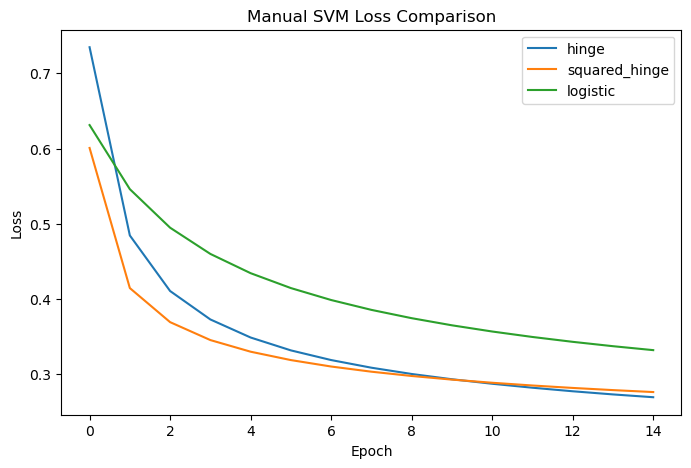

In [31]:
plt.figure(figsize=(8,5))

for loss in loss_types:
    plt.plot(manual_models[loss].losses, label=loss)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Manual SVM Loss Comparison")
plt.legend()
plt.show()


Manual SVM Results Table

In [32]:
results_df = pd.DataFrame.from_dict(
    metrics,
    orient="index",
    columns=["Accuracy", "Precision", "Recall", "F1"]
)

results_df


,Accuracy,Precision,Recall,F1
hinge,0.8874,0.875168,0.905735,0.890189
squared_hinge,0.8881,0.878378,0.902957,0.890498
logistic,0.8759,0.854291,0.908712,0.880662


📓 CELL 10 — Library-Based SVM (Benchmark)

In [33]:
lib_svm = LinearSVC(loss="hinge")
lib_svm.fit(X_train_vec, y_train)

lib_preds = lib_svm.predict(X_test_vec)

lib_acc = accuracy_score(y_test, lib_preds)
lib_p, lib_r, lib_f1, _ = precision_recall_fscore_support(
    y_test, lib_preds, average="binary"
)

lib_acc, lib_p, lib_r, lib_f1


(0.8846, 0.8765264586160109, 0.8974002778329033, 0.8868405569719553)

Comparison Table (Manual vs Library)

In [21]:
comparison = results_df.copy()
comparison.loc["library_svm"] = [lib_acc, lib_p, lib_r, lib_f1]

comparison


,Accuracy,Precision,Recall,F1
hinge,0.8874,0.875168,0.905735,0.890189
squared_hinge,0.8881,0.878378,0.902957,0.890498
logistic,0.8759,0.854291,0.908712,0.880662
library_svm,0.8846,0.876526,0.897400,0.886841


📓 CELL 12 — Save Best Model

In [22]:
best_model = lib_svm  # usually best
joblib.dump(best_model, "best_model.pkl")

print("Best model saved.")


Best model saved.


📓 CELL 13 — Quick Prediction Test

In [23]:
sample = ["This movie was boring and a waste of time"]

X_sample = vectorizer.transform(sample).toarray()
prediction = best_model.predict(X_sample)

prediction


array([-1])